In [ ]:
class NeuralNetwork:
    def __init__(self, layers, lr=0.01, activation='relu', weight_init='xavier', epochs=100, batch_size=32):
        self.layers = layers
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.weight_init = weight_init
        self.activation_func = self.get_activation_func(activation)
        self.activation_derivative = self.get_activation_derivative(activation)
        self.initialize_weights()

    def initialize_weights(self):
        self.weights = []
        self.biases = []

        for i in range(1, len(self.layers)):
            shape = (self.layers[i], self.layers[i-1])
            if self.weight_init == 'zero':
                weight = WeightInitialization.zero_init(shape)
            elif self.weight_init == 'random':
                weight = WeightInitialization.random_init(shape, scale=0.01)
            elif self.weight_init == 'normal':
                weight = WeightInitialization.normal_init(shape, scale=np.sqrt(2 / self.layers[i-1]))
            else:
                raise ValueError("Unsupported weight initialization method.")

            bias = np.zeros((self.layers[i], 1))  # Initialize biases to zero
            self.weights.append(weight)
            self.biases.append(bias)

    def get_activation_func(self, name):
        """Return the activation function."""
        if name == 'relu':
            return self.relu
        elif name == 'sigmoid':
            return self.sigmoid
        elif name == 'tanh':
            return self.tanh
        elif name == 'leaky_relu':
            return self.leaky_relu  # Use instance method
        else:
            raise ValueError("Unsupported activation function.")

    def get_activation_derivative(self, name):
        """Return the derivative of the activation function."""
        if name == 'relu':
            return self.relu_derivative
        elif name == 'sigmoid':
            return self.sigmoid_derivative
        elif name == 'tanh':
            return self.tanh_derivative
        elif name == 'leaky_relu':
            return self.leaky_relu_derivative  # Use instance method
        else:
            raise ValueError("Unsupported activation function.")

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2

    def leaky_relu(self, x, alpha=0.01):
        """ Leaky ReLU activation function """
        return np.where(x > 0, x, alpha * x)

    def leaky_relu_derivative(self, x, alpha=0.01):
        """ Derivative of Leaky ReLU activation function """
        return np.where(x > 0, 1, alpha)

    def softmax(self, x):
        """Compute softmax values for each set of scores in x."""
        exp_x = np.exp(x - np.max(x, axis=0, keepdims=True))
        return exp_x / np.sum(exp_x, axis=0, keepdims=True)

    def forward(self, X):
        """Perform forward propagation."""
        self.a = [X]
        for i in range(len(self.weights) - 1):
            z = np.dot(self.weights[i], self.a[-1]) + self.biases[i]
            a = self.activation_func(z)
            self.a.append(a)

        # Output layer
        z = np.dot(self.weights[-1], self.a[-1]) + self.biases[-1]
        a = self.softmax(z)
        self.a.append(a)

        return self.a[-1]

    def backward(self, X, Y):
        """Perform backpropagation and update weights."""
        m = Y.shape[1]
        dZ = self.a[-1] - Y

        for i in reversed(range(len(self.weights))):
            dW = (1 / m) * np.dot(dZ, self.a[i].T)
            dB = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
            dA = np.dot(self.weights[i].T, dZ)

            # Update weights and biases
            self.weights[i] -= self.lr * dW
            self.biases[i] -= self.lr * dB

            if i > 0:  # Skip activation derivative for the output layer
                dZ = dA * self.activation_derivative(self.a[i])

    def fit(self, X, Y):
        X = np.array(X).T  # Convert to numpy array and transpose for column vector format
        Y = np.array(Y).T

        for i in range(0, X.shape[1], self.batch_size):
            X_batch = X[:, i:i + self.batch_size]
            Y_batch = Y[:, i:i + self.batch_size]

            # Forward propagation
            self.forward(X_batch)

            # Backward propagation and weight update
            self.backward(X_batch, Y_batch)


    def predict(self, X):
        """Predict class labels for input X."""
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)  # Return predicted labels as 1D array

    def score(self, X, Y):
        """Compute the accuracy of the model."""
        Y_pred = self.predict(X)
        Y_true = np.argmax(Y, axis=1)  # Ensure Y_true is also in 1D label format
        accuracy = np.mean(Y_pred == Y_true)
        return accuracy


    def predict_proba(self, X):
        """Predict probabilities for input X."""
        X = X.T
        probabilities = self.forward(X)
        return probabilities.T


In [ ]:
import numpy as np

class Activations:
    @staticmethod
    def sigmoid(x):
        """ Sigmoid activation function """
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def sigmoid_derivative(x):
        """ Derivative of sigmoid activation function """
        s = Activations.sigmoid(x)
        return s * (1 - s)

    @staticmethod
    def tanh(x):
        """ Tanh activation function """
        return np.tanh(x)

    @staticmethod
    def tanh_derivative(x):
        """ Derivative of tanh activation function """
        return 1 - np.tanh(x) ** 2

    @staticmethod
    def relu(x):
        """ ReLU activation function """
        return np.maximum(0, x)

    @staticmethod
    def relu_derivative(x):
        """ Derivative of ReLU activation function """
        return np.where(x > 0, 1, 0)

    @staticmethod
    def leaky_relu(x, alpha=0.01):
        """ Leaky ReLU activation function """
        return np.where(x > 0, x, alpha * x)

    @staticmethod
    def leaky_relu_derivative(x, alpha=0.01):
        """ Derivative of Leaky ReLU activation function """
        return np.where(x > 0, 1, alpha)

    @staticmethod
    def softmax(x):
        """ Softmax activation function (usually applied to the last layer) """
        exp_x = np.exp(x - np.max(x, axis=0, keepdims=True))
        return exp_x / np.sum(exp_x, axis=0, keepdims=True)


In [ ]:
import numpy as np

class WeightInitialization:
    @staticmethod
    def zero_init(shape):
        return np.zeros(shape)

    @staticmethod
    def random_init(shape, scale=0.01):

        return np.random.rand(*shape) * scale

    @staticmethod
    def normal_init(shape, scale=1.0):
        return np.random.randn(*shape) * scale


In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Load MNIST dataset
def load_and_preprocess_mnist():
    mnist = fetch_openml('mnist_784')
    X = mnist.data / 255.0  # Normalize pixel values
    y = mnist.target.astype(np.int64)

    # One-hot encode the labels
    encoder = OneHotEncoder(sparse_output=False, categories='auto')
    y=np.array(y)
    y = encoder.fit_transform(y.reshape(-1, 1))

    # Split the data into train, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = load_and_preprocess_mnist()


# without early stopping

In [ ]:
# from google.colab import drive
# import pickle
# import os

# def train_and_evaluate_model(activation, weight_init, model_name):
#     # Initialize the model
#     nn = NeuralNetwork(
#         layers=[784, 256, 128, 64, 32, 10],  # input size 784, hidden layers, output size 10
#         lr=0.1,
#         activation=activation,
#         weight_init=weight_init,
#         epochs=100,
#         batch_size=128
#     )

#     # Track loss over epochs
#     train_losses = []
#     val_losses = []
#     train_accuracies, val_accuracies = [], []

#     for epoch in range(nn.epochs):
#         # Train the model on training data
#         nn.fit(X_train, y_train)

#         # Calculate training loss
#         train_pred = nn.predict_proba(X_train)
#         train_loss = -np.mean(y_train * np.log(train_pred + 1e-8))
#         train_losses.append(train_loss)

#         train_accuracy = nn.score(X_train, y_train)
#         train_accuracies.append(train_accuracy)

#         # Calculate validation loss
#         val_pred = nn.predict_proba(X_val)
#         val_loss = -np.mean(y_val * np.log(val_pred + 1e-8))
#         val_losses.append(val_loss)

#         val_accuracy = nn.score(X_val, y_val)
#         val_accuracies.append(val_accuracy)

#         print(f"Epoch {epoch+1}/{nn.epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
#               f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

#     # Plot training and validation loss
#     plt.figure()
#     plt.plot(range(1, nn.epochs + 1), train_losses, label='Training Loss')
#     plt.plot(range(1, nn.epochs + 1), val_losses, label='Validation Loss')
#     plt.xlabel("Epochs")
#     plt.ylabel("Loss")
#     plt.title(f"Training and Validation Loss - {activation} Activation, {weight_init} Init")
#     plt.legend()
#     plt.show()

#     # Plot training and validation accuracy
#     plt.figure()
#     plt.plot(range(1, nn.epochs + 1), train_accuracies, label='Training Accuracy')
#     plt.plot(range(1, nn.epochs + 1), val_accuracies, label='Validation Accuracy')
#     plt.xlabel("Epochs")
#     plt.ylabel("Accuracy")
#     plt.title(f"Training and Validation Accuracy - {activation} Activation, {weight_init} Init")
#     plt.legend()
#     plt.show()

#     # Save the model

#     drive.mount('/content/drive')
#     # Define a path in Google Drive
#     drive_path = '/content/drive/MyDrive/NN_models/'
#     os.makedirs(drive_path, exist_ok=True)
#     with open(os.path.join(drive_path, f'{model_name}.pkl'), 'wb') as f:
#         pickle.dump(nn, f)
#     print(f"Model saved in Google Drive as {os.path.join(drive_path, model_name)}.pkl")

#     # with open(f'{model_name}.pkl', 'wb') as f:
#     #     pickle.dump(nn, f)
#     # print(f"Model saved as {model_name}.pkl")

# # Define combinations of activation functions and weight initializations
# activations = ['tanh','relu', 'sigmoid']
# weight_initializations = ['normal','zero', 'random']

# # Train models for each combination and save them
# for activation in activations:
#     for weight_init in weight_initializations:
#         model_name = f"model_{activation}_{weight_init}"
#         print(f"Training model with {activation} activation and {weight_init} weight initialization")
#         train_and_evaluate_model(activation, weight_init, model_name)

#with early stopping(3 act funcs):

Training model with tanh activation and normal weight initialization
Epoch 1/100 - Train Loss: 0.0278, Val Loss: 0.0312, Train Acc: 0.9199, Val Acc: 0.9084
Epoch 2/100 - Train Loss: 0.0183, Val Loss: 0.0224, Train Acc: 0.9453, Val Acc: 0.9324
Epoch 3/100 - Train Loss: 0.0139, Val Loss: 0.0182, Train Acc: 0.9580, Val Acc: 0.9443
Epoch 4/100 - Train Loss: 0.0110, Val Loss: 0.0155, Train Acc: 0.9669, Val Acc: 0.9520
Epoch 5/100 - Train Loss: 0.0091, Val Loss: 0.0139, Train Acc: 0.9726, Val Acc: 0.9573
Epoch 6/100 - Train Loss: 0.0075, Val Loss: 0.0126, Train Acc: 0.9773, Val Acc: 0.9613
Epoch 7/100 - Train Loss: 0.0064, Val Loss: 0.0118, Train Acc: 0.9798, Val Acc: 0.9637
Epoch 8/100 - Train Loss: 0.0056, Val Loss: 0.0113, Train Acc: 0.9825, Val Acc: 0.9651
Epoch 9/100 - Train Loss: 0.0051, Val Loss: 0.0111, Train Acc: 0.9841, Val Acc: 0.9641
Epoch 10/100 - Train Loss: 0.0046, Val Loss: 0.0111, Train Acc: 0.9857, Val Acc: 0.9651
Early stopping at epoch 10 due to no improvement in validati

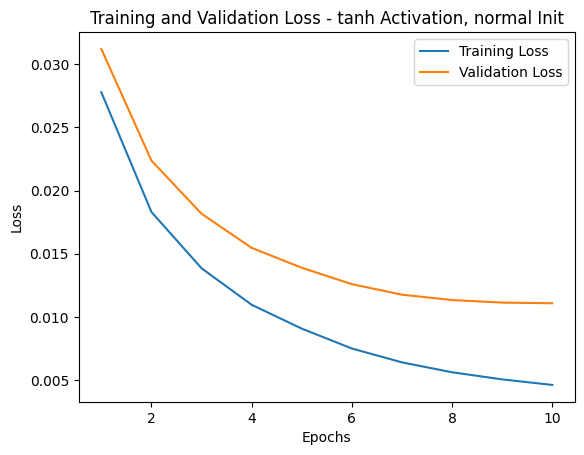

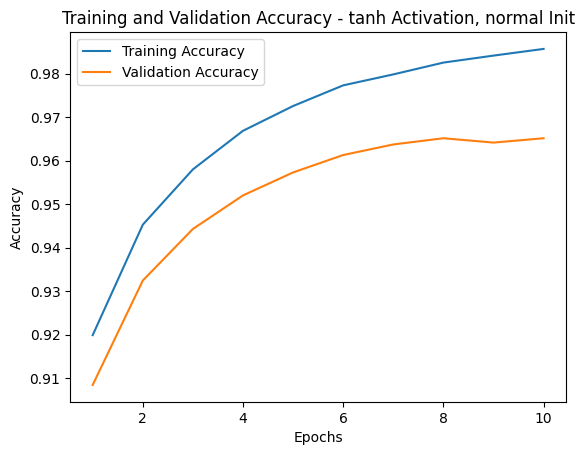

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved in Google Drive as /content/drive/MyDrive/NN_models/model_tanh_normal.pkl
Training model with tanh activation and zero weight initialization
Epoch 1/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 2/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 3/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 4/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 5/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 6/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 7/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 8/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 9/100 - Train Lo

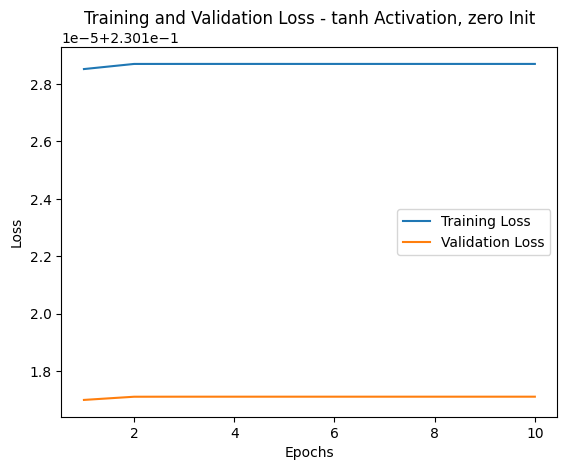

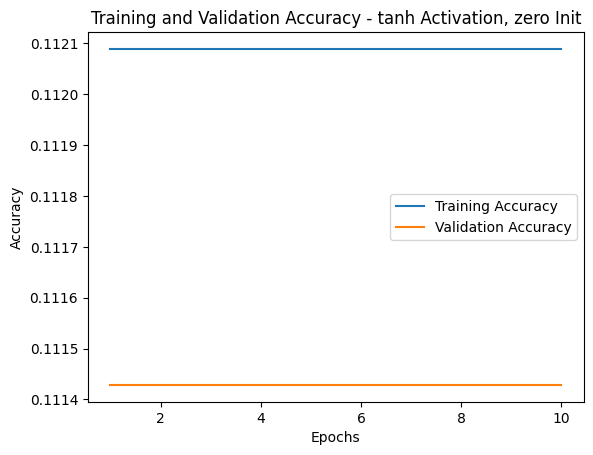

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved in Google Drive as /content/drive/MyDrive/NN_models/model_tanh_zero.pkl
Training model with tanh activation and random weight initialization
Epoch 1/100 - Train Loss: 0.1834, Val Loss: 0.1843, Train Acc: 0.2589, Val Acc: 0.2589
Epoch 2/100 - Train Loss: 0.1655, Val Loss: 0.1665, Train Acc: 0.3463, Val Acc: 0.3449
Epoch 3/100 - Train Loss: 0.1577, Val Loss: 0.1586, Train Acc: 0.3829, Val Acc: 0.3763
Epoch 4/100 - Train Loss: 0.1445, Val Loss: 0.1453, Train Acc: 0.4402, Val Acc: 0.4317
Epoch 5/100 - Train Loss: 0.1209, Val Loss: 0.1220, Train Acc: 0.5912, Val Acc: 0.5896
Epoch 6/100 - Train Loss: 0.0964, Val Loss: 0.0983, Train Acc: 0.6565, Val Acc: 0.6541
Epoch 7/100 - Train Loss: 0.0663, Val Loss: 0.0682, Train Acc: 0.7784, Val Acc: 0.7723
Epoch 8/100 - Train Loss: 0.0481, Val Loss: 0.0504, Train Acc: 0.8646, Val Acc: 0.8564
Epoch 9/100 - Train Lo

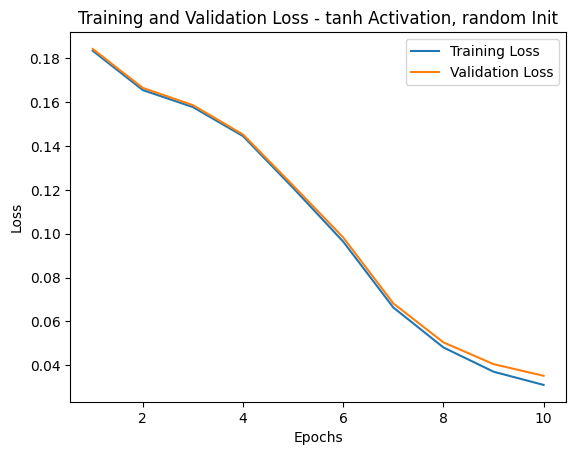

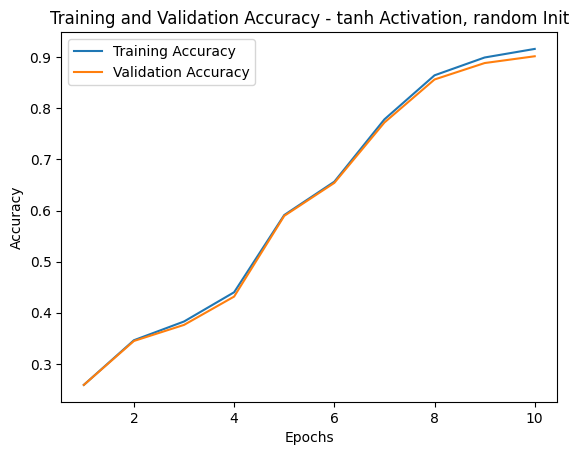

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved in Google Drive as /content/drive/MyDrive/NN_models/model_tanh_random.pkl
Training model with relu activation and normal weight initialization
Epoch 1/100 - Train Loss: 0.0207, Val Loss: 0.0240, Train Acc: 0.9383, Val Acc: 0.9293
Epoch 2/100 - Train Loss: 0.0107, Val Loss: 0.0150, Train Acc: 0.9684, Val Acc: 0.9540
Epoch 3/100 - Train Loss: 0.0080, Val Loss: 0.0129, Train Acc: 0.9763, Val Acc: 0.9604
Epoch 4/100 - Train Loss: 0.0059, Val Loss: 0.0115, Train Acc: 0.9823, Val Acc: 0.9663
Epoch 5/100 - Train Loss: 0.0049, Val Loss: 0.0114, Train Acc: 0.9852, Val Acc: 0.9664
Epoch 6/100 - Train Loss: 0.0040, Val Loss: 0.0112, Train Acc: 0.9880, Val Acc: 0.9674
Epoch 7/100 - Train Loss: 0.0031, Val Loss: 0.0107, Train Acc: 0.9904, Val Acc: 0.9693
Epoch 8/100 - Train Loss: 0.0026, Val Loss: 0.0105, Train Acc: 0.9921, Val Acc: 0.9711
Epoch 9/100 - Train 

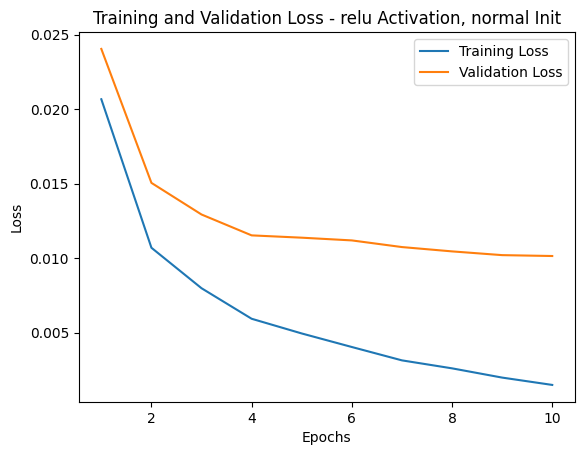

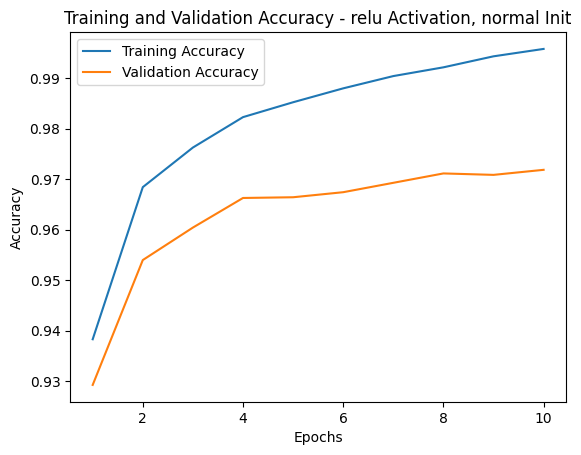

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved in Google Drive as /content/drive/MyDrive/NN_models/model_relu_normal.pkl
Training model with relu activation and zero weight initialization
Epoch 1/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 2/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 3/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 4/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 5/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 6/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 7/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 8/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 9/100 - Train Lo

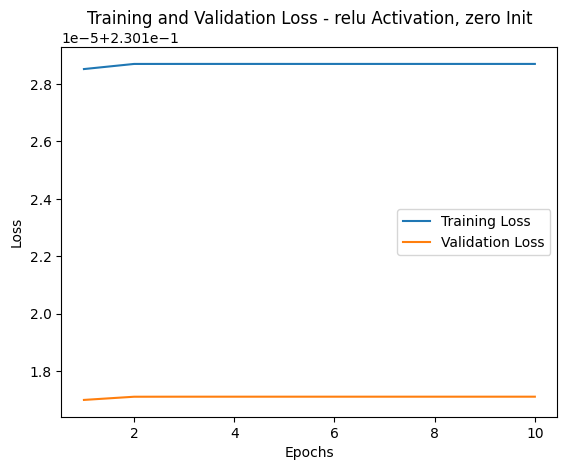

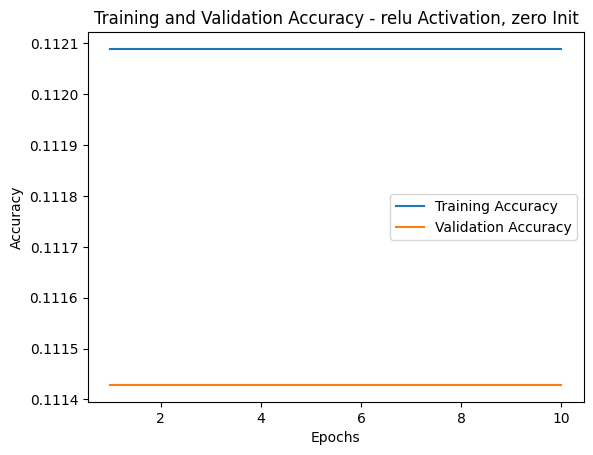

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved in Google Drive as /content/drive/MyDrive/NN_models/model_relu_zero.pkl
Training model with relu activation and random weight initialization
Epoch 1/100 - Train Loss: 0.1832, Val Loss: 0.1844, Train Acc: 0.2563, Val Acc: 0.2549
Epoch 2/100 - Train Loss: 0.1613, Val Loss: 0.1631, Train Acc: 0.3194, Val Acc: 0.3214
Epoch 3/100 - Train Loss: 0.1493, Val Loss: 0.1504, Train Acc: 0.3554, Val Acc: 0.3534
Epoch 4/100 - Train Loss: 0.1428, Val Loss: 0.1438, Train Acc: 0.3793, Val Acc: 0.3760
Epoch 5/100 - Train Loss: 0.1369, Val Loss: 0.1384, Train Acc: 0.3900, Val Acc: 0.3860
Epoch 6/100 - Train Loss: 0.1311, Val Loss: 0.1331, Train Acc: 0.4187, Val Acc: 0.4121
Epoch 7/100 - Train Loss: 0.1270, Val Loss: 0.1301, Train Acc: 0.4459, Val Acc: 0.4406
Epoch 8/100 - Train Loss: 0.1247, Val Loss: 0.1278, Train Acc: 0.4392, Val Acc: 0.4334
Epoch 9/100 - Train Lo

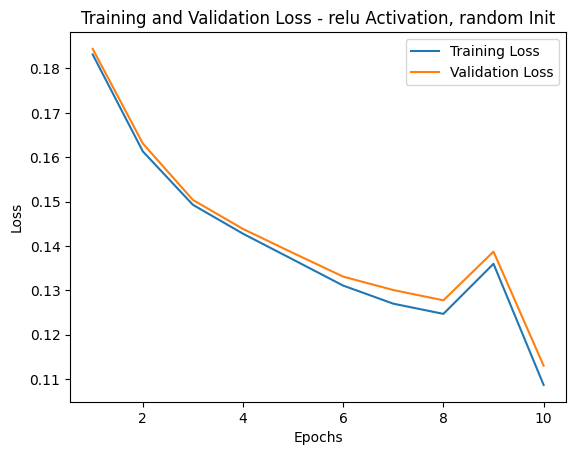

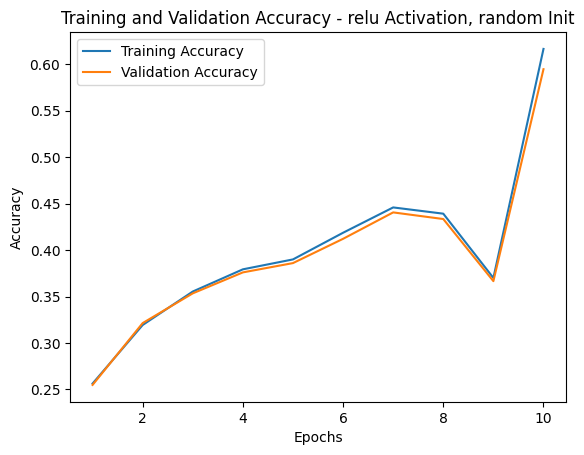

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved in Google Drive as /content/drive/MyDrive/NN_models/model_relu_random.pkl
Training model with sigmoid activation and normal weight initialization
Epoch 1/100 - Train Loss: 0.2291, Val Loss: 0.2289, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 2/100 - Train Loss: 0.2252, Val Loss: 0.2251, Train Acc: 0.1594, Val Acc: 0.1617
Epoch 3/100 - Train Loss: 0.1797, Val Loss: 0.1796, Train Acc: 0.3811, Val Acc: 0.3879
Epoch 4/100 - Train Loss: 0.1359, Val Loss: 0.1367, Train Acc: 0.4711, Val Acc: 0.4723
Epoch 5/100 - Train Loss: 0.1329, Val Loss: 0.1349, Train Acc: 0.4967, Val Acc: 0.4946
Epoch 6/100 - Train Loss: 0.1272, Val Loss: 0.1292, Train Acc: 0.5303, Val Acc: 0.5281
Epoch 7/100 - Train Loss: 0.1095, Val Loss: 0.1112, Train Acc: 0.6128, Val Acc: 0.6087
Epoch 8/100 - Train Loss: 0.0842, Val Loss: 0.0858, Train Acc: 0.7213, Val Acc: 0.7187
Epoch 9/100 - Tra

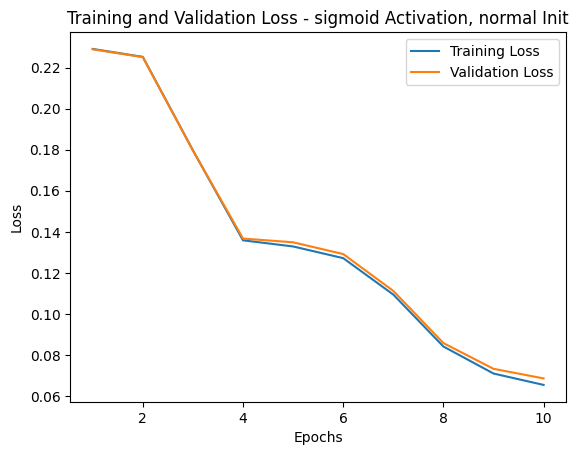

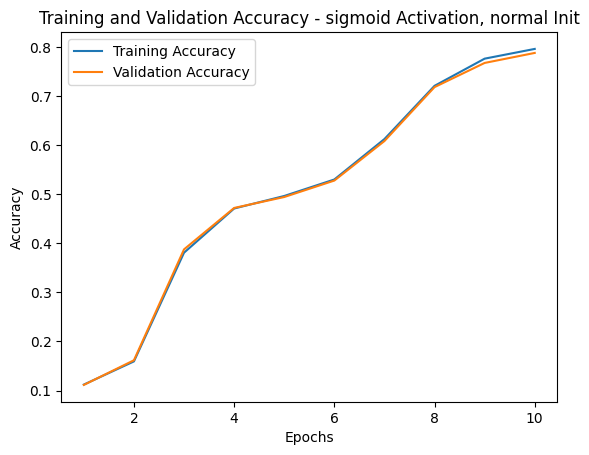

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved in Google Drive as /content/drive/MyDrive/NN_models/model_sigmoid_normal.pkl
Training model with sigmoid activation and zero weight initialization
Epoch 1/100 - Train Loss: 0.2303, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 2/100 - Train Loss: 0.2303, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 3/100 - Train Loss: 0.2303, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 4/100 - Train Loss: 0.2302, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 5/100 - Train Loss: 0.2302, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 6/100 - Train Loss: 0.2302, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 7/100 - Train Loss: 0.2302, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 8/100 - Train Loss: 0.2302, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 9/100 - Tr

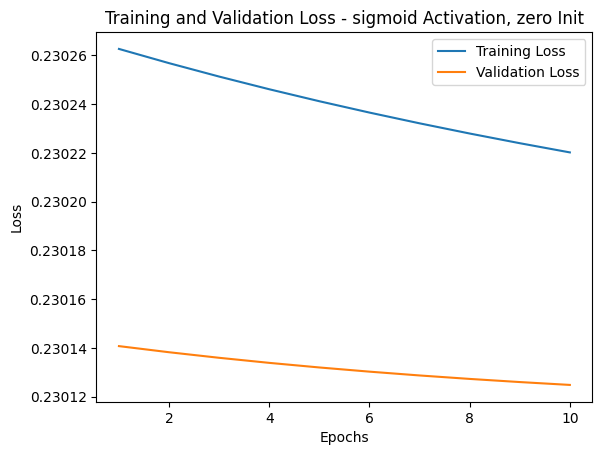

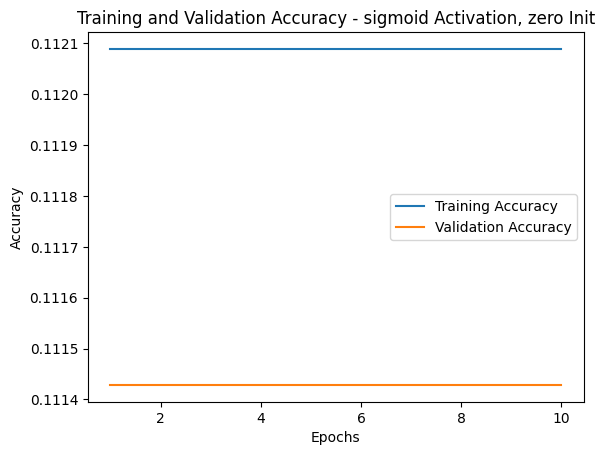

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved in Google Drive as /content/drive/MyDrive/NN_models/model_sigmoid_zero.pkl
Training model with sigmoid activation and random weight initialization
Epoch 1/100 - Train Loss: 0.2303, Val Loss: 0.2302, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 2/100 - Train Loss: 0.2303, Val Loss: 0.2302, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 3/100 - Train Loss: 0.2303, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 4/100 - Train Loss: 0.2303, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 5/100 - Train Loss: 0.2303, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 6/100 - Train Loss: 0.2302, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 7/100 - Train Loss: 0.2302, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 8/100 - Train Loss: 0.2302, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 9/100 - Tr

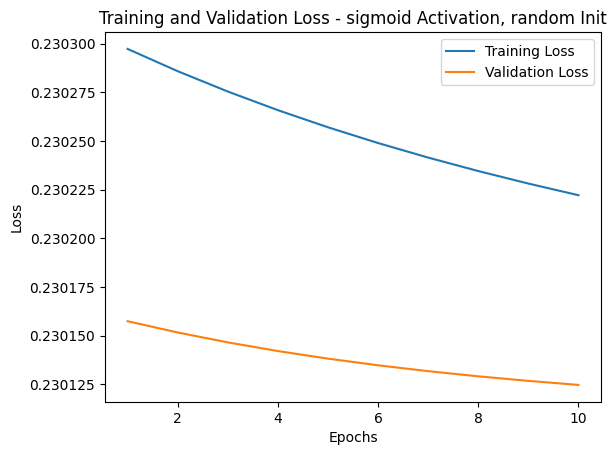

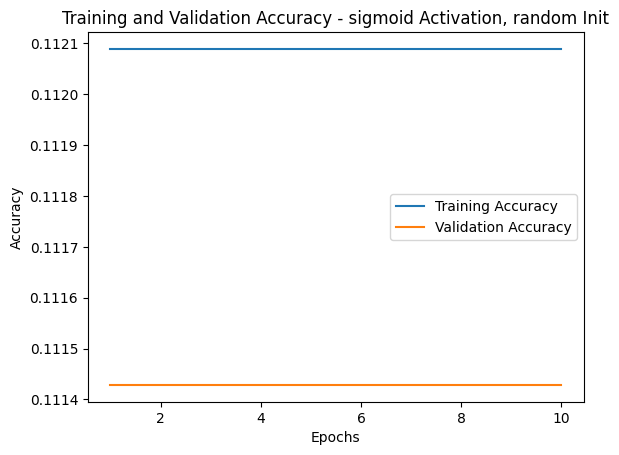

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved in Google Drive as /content/drive/MyDrive/NN_models/model_sigmoid_random.pkl


In [ ]:
from google.colab import drive
import pickle
import os

def train_and_evaluate_model(activation, weight_init, model_name, patience=10):
    # Initialize the model
    nn = NeuralNetwork(
        layers=[784, 256, 128, 64, 32, 10],  # input size 784, hidden layers, output size 10
        lr=0.1,
        activation=activation,
        weight_init=weight_init,
        epochs=100,
        batch_size=128
    )

    # Track loss and accuracy over epochs
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(nn.epochs):
        nn.fit(X_train, y_train)

        train_pred = nn.predict_proba(X_train)
        train_loss = -np.mean(y_train * np.log(train_pred + 1e-8))
        train_accuracy = nn.score(X_train, y_train)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        val_pred = nn.predict_proba(X_val)
        val_loss = -np.mean(y_val * np.log(val_pred + 1e-8))
        val_accuracy = nn.score(X_val, y_val)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{nn.epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

        # Early stopping checkkkkkkkkkk ddd
        if val_loss < best_val_loss:
        # if val_loss < 0.001:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1} due to no improvement in validation loss.")
                break

    plt.figure()
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Training and Validation Loss - {activation} Activation, {weight_init} Init")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Training and Validation Accuracy - {activation} Activation, {weight_init} Init")
    plt.legend()
    plt.show()

    drive.mount('/content/drive')
    drive_path = '/content/drive/MyDrive/NN_models/'
    os.makedirs(drive_path, exist_ok=True)
    with open(os.path.join(drive_path, f'{model_name}.pkl'), 'wb') as f:
        pickle.dump(nn, f)
    print(f"Model saved in Google Drive as {os.path.join(drive_path, model_name)}.pkl")

# Define combinations of activation functions and weight initializations
activations = ['tanh', 'relu', 'sigmoid']
weight_initializations = ['normal', 'zero', 'random']

# Train models for each combination and save them with early stopping
for activation in activations:
    for weight_init in weight_initializations:
        model_name = f"model_{activation}_{weight_init}"
        print(f"Training model with {activation} activation and {weight_init} weight initialization")
        train_and_evaluate_model(activation, weight_init, model_name, patience=10)


#with early stopping(1 act funcs- leaky_relu):

Training model with leaky_relu activation and normal weight initialization
Epoch 1/100 - Train Loss: 0.0166, Val Loss: 0.0202, Train Acc: 0.9499, Val Acc: 0.9397
Epoch 2/100 - Train Loss: 0.0104, Val Loss: 0.0150, Train Acc: 0.9685, Val Acc: 0.9566
Epoch 3/100 - Train Loss: 0.0075, Val Loss: 0.0126, Train Acc: 0.9774, Val Acc: 0.9630
Epoch 4/100 - Train Loss: 0.0058, Val Loss: 0.0115, Train Acc: 0.9823, Val Acc: 0.9663
Epoch 5/100 - Train Loss: 0.0043, Val Loss: 0.0106, Train Acc: 0.9870, Val Acc: 0.9684
Epoch 6/100 - Train Loss: 0.0036, Val Loss: 0.0107, Train Acc: 0.9888, Val Acc: 0.9706
Epoch 7/100 - Train Loss: 0.0036, Val Loss: 0.0115, Train Acc: 0.9885, Val Acc: 0.9693
Epoch 8/100 - Train Loss: 0.0030, Val Loss: 0.0117, Train Acc: 0.9900, Val Acc: 0.9676
Epoch 9/100 - Train Loss: 0.0024, Val Loss: 0.0115, Train Acc: 0.9920, Val Acc: 0.9693
Epoch 10/100 - Train Loss: 0.0018, Val Loss: 0.0116, Train Acc: 0.9944, Val Acc: 0.9703
Early stopping at epoch 10 due to no improvement in va

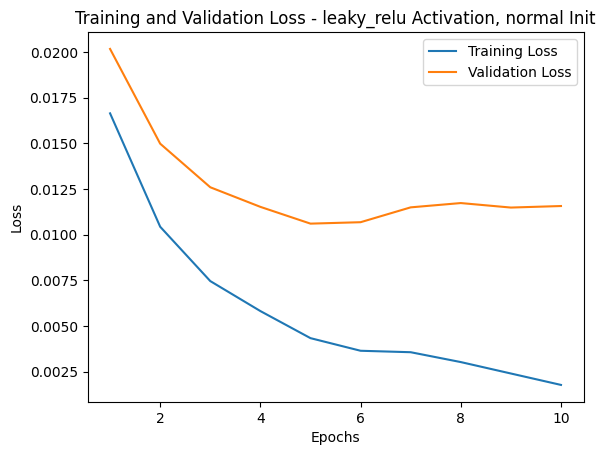

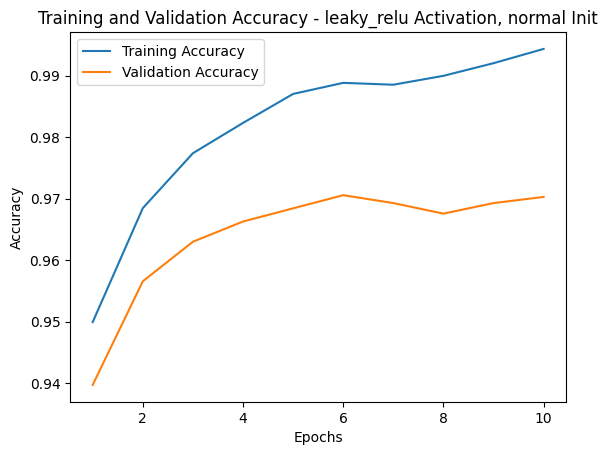

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved in Google Drive as /content/drive/MyDrive/NN_models/model_leaky_relu_normal.pkl
Training model with leaky_relu activation and zero weight initialization
Epoch 1/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 2/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 3/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 4/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 5/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 6/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 7/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 8/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 9/10

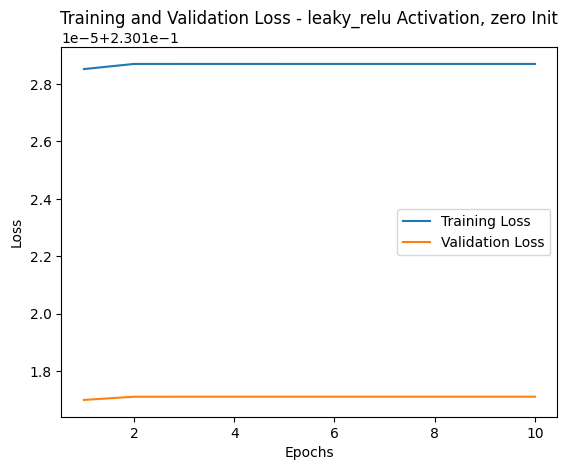

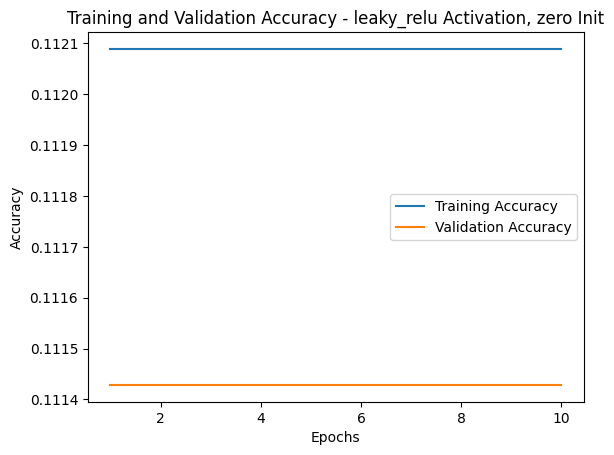

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved in Google Drive as /content/drive/MyDrive/NN_models/model_leaky_relu_zero.pkl
Training model with leaky_relu activation and random weight initialization
Epoch 1/100 - Train Loss: 0.1828, Val Loss: 0.1840, Train Acc: 0.2580, Val Acc: 0.2550
Epoch 2/100 - Train Loss: 0.1612, Val Loss: 0.1630, Train Acc: 0.3209, Val Acc: 0.3254
Epoch 3/100 - Train Loss: 0.1495, Val Loss: 0.1506, Train Acc: 0.3571, Val Acc: 0.3573
Epoch 4/100 - Train Loss: 0.1438, Val Loss: 0.1448, Train Acc: 0.3702, Val Acc: 0.3669
Epoch 5/100 - Train Loss: 0.1361, Val Loss: 0.1375, Train Acc: 0.3927, Val Acc: 0.3899
Epoch 6/100 - Train Loss: 0.1285, Val Loss: 0.1304, Train Acc: 0.4343, Val Acc: 0.4271
Epoch 7/100 - Train Loss: 0.1246, Val Loss: 0.1272, Train Acc: 0.4319, Val Acc: 0.4253
Epoch 8/100 - Train Loss: 0.1244, Val Loss: 0.1274, Train Acc: 0.4374, Val Acc: 0.4317
Epoch 9/10

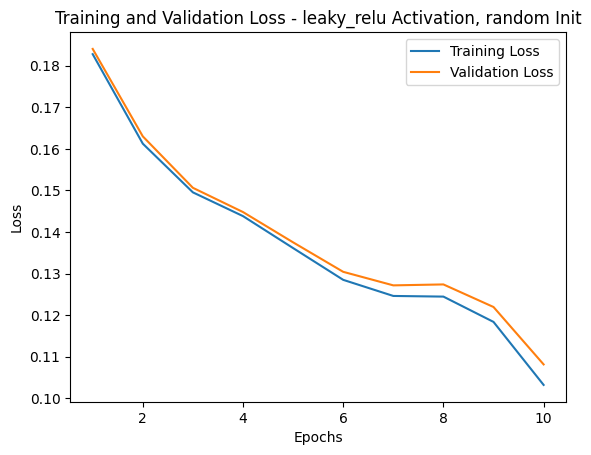

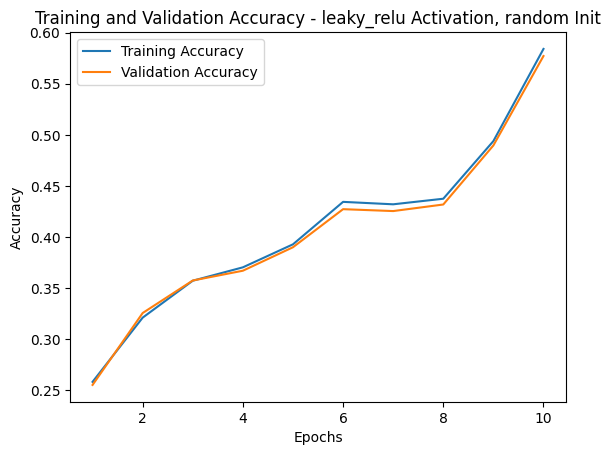

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved in Google Drive as /content/drive/MyDrive/NN_models/model_leaky_relu_random.pkl


In [ ]:
from google.colab import drive
import pickle
import os

def train_and_evaluate_model(activation, weight_init, model_name, patience=10):
    nn = NeuralNetwork(
        layers=[784, 256, 128, 64, 32, 10],  # input size 784, hidden layers, output size 10
        lr=0.1,
        activation=activation,
        weight_init=weight_init,
        epochs=100,
        batch_size=128
    )

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(nn.epochs):
        nn.fit(X_train, y_train)

        train_pred = nn.predict_proba(X_train)
        train_loss = -np.mean(y_train * np.log(train_pred + 1e-8))
        train_accuracy = nn.score(X_train, y_train)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        val_pred = nn.predict_proba(X_val)
        val_loss = -np.mean(y_val * np.log(val_pred + 1e-8))
        val_accuracy = nn.score(X_val, y_val)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{nn.epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

        if val_loss < 0.001:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1} due to no improvement in validation loss.")
                break

    plt.figure()
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Training and Validation Loss - {activation} Activation, {weight_init} Init")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Training and Validation Accuracy - {activation} Activation, {weight_init} Init")
    plt.legend()
    plt.show()

    # Save the model to Google Drive
    drive.mount('/content/drive')
    drive_path = '/content/drive/MyDrive/NN_models/'
    os.makedirs(drive_path, exist_ok=True)
    with open(os.path.join(drive_path, f'{model_name}.pkl'), 'wb') as f:
        pickle.dump(nn, f)
    print(f"Model saved in Google Drive as {os.path.join(drive_path, model_name)}.pkl")

# Define combinations of activation functions and weight initializations
activations = ['leaky_relu']
weight_initializations = ['normal', 'zero', 'random']

# Train models for each combination and save them with early stopping
for activation in activations:
    for weight_init in weight_initializations:
        model_name = f"model_{activation}_{weight_init}"
        print(f"Training model with {activation} activation and {weight_init} weight initialization")
        train_and_evaluate_model(activation, weight_init, model_name, patience=10)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model loaded from: /content/drive/MyDrive/NN_models/model_tanh_normal.pkl
Test Accuracy: 97.07%


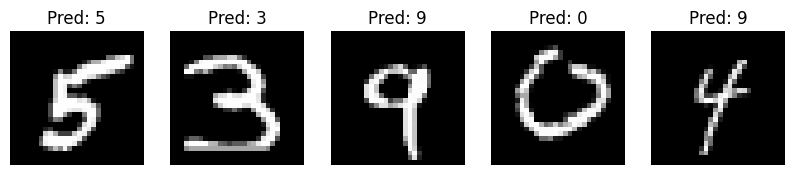

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

model_path = '/content/drive/MyDrive/NN_models/model_tanh_normal.pkl'

with open(model_path, 'rb') as f:
    nn = pickle.load(f)

print(f"Model loaded from: {model_path}")


y_pred = nn.predict(X_test)

y_test_labels = np.argmax(y_test, axis=1)  # Convert one-hot encoding to class labels
accuracy = np.mean(y_pred == y_test_labels)

print(f"Test Accuracy: {accuracy * 100:.2f}%")

X_test = X_test.to_numpy()

num_images_to_show = 5
plt.figure(figsize=(10, 5))
for i in range(num_images_to_show):
    plt.subplot(1, num_images_to_show, i + 1)
    img = X_test[i].reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.title(f"Pred: {y_pred[i]}")
    plt.axis('off')
plt.show()

Training model with leaky_relu activation and normal weight initialization
Epoch 1/100 - Train Loss: 0.0165, Val Loss: 0.0201, Train Acc: 0.9510, Val Acc: 0.9414
Epoch 2/100 - Train Loss: 0.0107, Val Loss: 0.0152, Train Acc: 0.9682, Val Acc: 0.9541
Epoch 3/100 - Train Loss: 0.0078, Val Loss: 0.0130, Train Acc: 0.9769, Val Acc: 0.9620
Epoch 4/100 - Train Loss: 0.0058, Val Loss: 0.0116, Train Acc: 0.9826, Val Acc: 0.9661
Epoch 5/100 - Train Loss: 0.0044, Val Loss: 0.0107, Train Acc: 0.9872, Val Acc: 0.9683
Epoch 6/100 - Train Loss: 0.0035, Val Loss: 0.0103, Train Acc: 0.9895, Val Acc: 0.9700
Epoch 7/100 - Train Loss: 0.0032, Val Loss: 0.0106, Train Acc: 0.9903, Val Acc: 0.9699
Epoch 8/100 - Train Loss: 0.0025, Val Loss: 0.0104, Train Acc: 0.9925, Val Acc: 0.9723
Epoch 9/100 - Train Loss: 0.0023, Val Loss: 0.0110, Train Acc: 0.9931, Val Acc: 0.9713
Epoch 10/100 - Train Loss: 0.0015, Val Loss: 0.0104, Train Acc: 0.9958, Val Acc: 0.9743
Epoch 11/100 - Train Loss: 0.0013, Val Loss: 0.0108, T

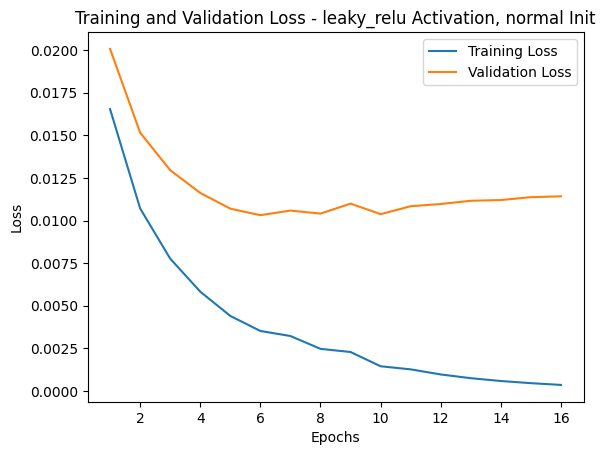

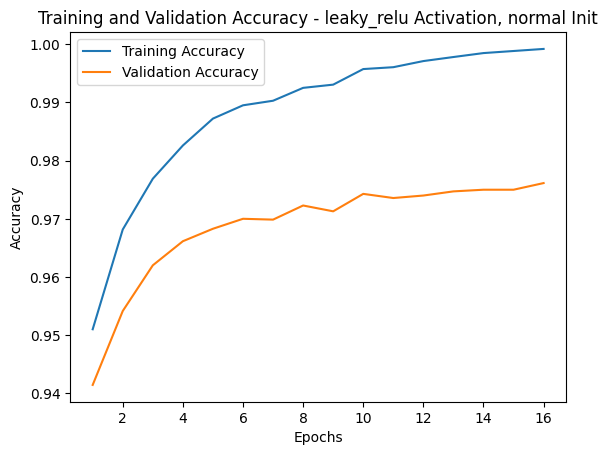

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved in Google Drive as /content/drive/MyDrive/NNN_models/model_leaky_relu_normal.pkl
Training model with leaky_relu activation and zero weight initialization
Epoch 1/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 2/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 3/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 4/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 5/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 6/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 7/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 8/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 9/1

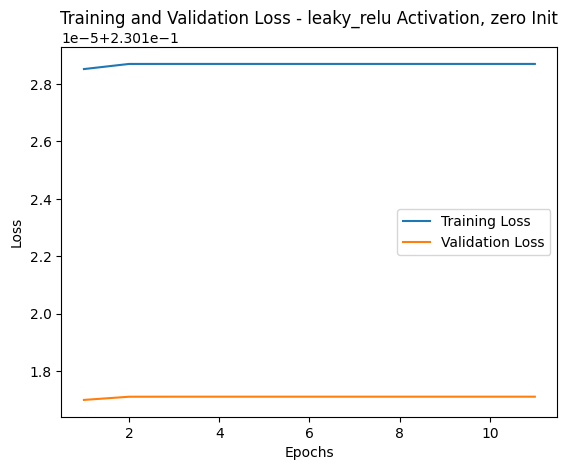

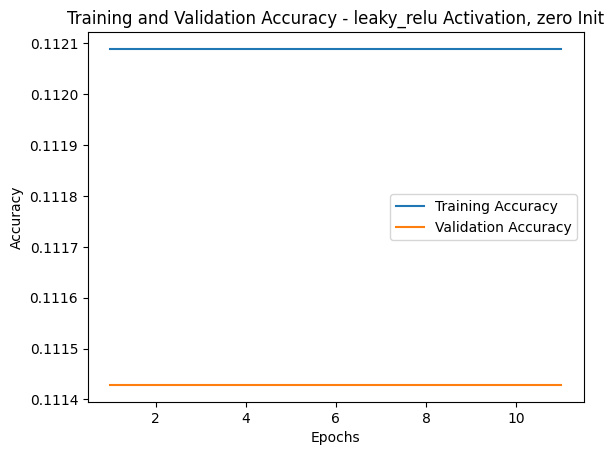

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved in Google Drive as /content/drive/MyDrive/NNN_models/model_leaky_relu_zero.pkl
Training model with leaky_relu activation and random weight initialization
Epoch 1/100 - Train Loss: 0.1828, Val Loss: 0.1840, Train Acc: 0.2568, Val Acc: 0.2543
Epoch 2/100 - Train Loss: 0.1615, Val Loss: 0.1633, Train Acc: 0.3206, Val Acc: 0.3260
Epoch 3/100 - Train Loss: 0.1495, Val Loss: 0.1506, Train Acc: 0.3553, Val Acc: 0.3530
Epoch 4/100 - Train Loss: 0.1431, Val Loss: 0.1442, Train Acc: 0.3772, Val Acc: 0.3713
Epoch 5/100 - Train Loss: 0.1371, Val Loss: 0.1386, Train Acc: 0.4006, Val Acc: 0.3961
Epoch 6/100 - Train Loss: 0.1313, Val Loss: 0.1333, Train Acc: 0.4165, Val Acc: 0.4154
Epoch 7/100 - Train Loss: 0.1290, Val Loss: 0.1319, Train Acc: 0.4195, Val Acc: 0.4166
Epoch 8/100 - Train Loss: 0.1201, Val Loss: 0.1233, Train Acc: 0.4695, Val Acc: 0.4670
Epoch 9/1

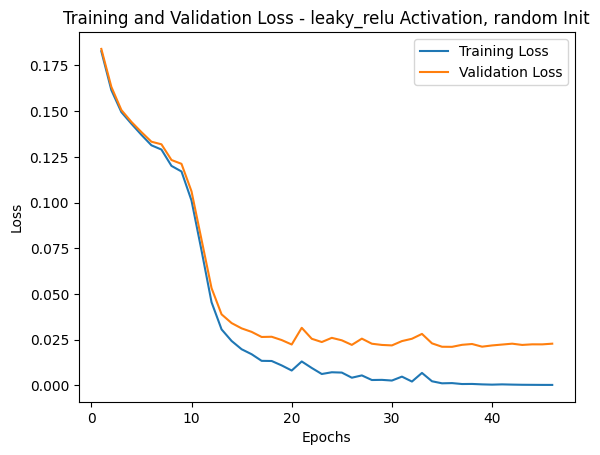

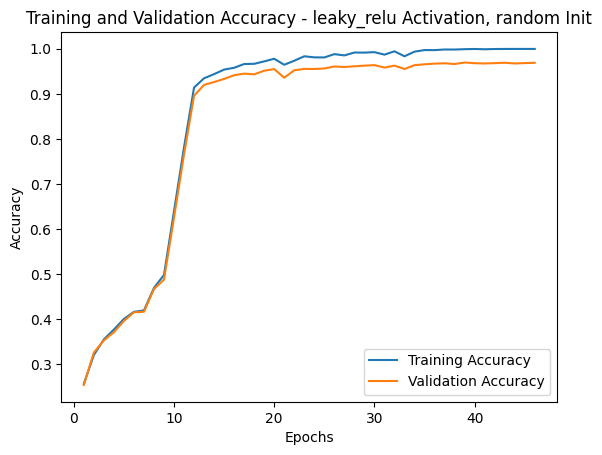

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved in Google Drive as /content/drive/MyDrive/NNN_models/model_leaky_relu_random.pkl
Training model with tanh activation and normal weight initialization
Epoch 1/100 - Train Loss: 0.0278, Val Loss: 0.0311, Train Acc: 0.9192, Val Acc: 0.9113
Epoch 2/100 - Train Loss: 0.0181, Val Loss: 0.0222, Train Acc: 0.9472, Val Acc: 0.9364
Epoch 3/100 - Train Loss: 0.0145, Val Loss: 0.0190, Train Acc: 0.9570, Val Acc: 0.9431
Epoch 4/100 - Train Loss: 0.0117, Val Loss: 0.0166, Train Acc: 0.9654, Val Acc: 0.9501
Epoch 5/100 - Train Loss: 0.0097, Val Loss: 0.0151, Train Acc: 0.9713, Val Acc: 0.9561
Epoch 6/100 - Train Loss: 0.0084, Val Loss: 0.0144, Train Acc: 0.9745, Val Acc: 0.9583
Epoch 7/100 - Train Loss: 0.0075, Val Loss: 0.0140, Train Acc: 0.9772, Val Acc: 0.9596
Epoch 8/100 - Train Loss: 0.0064, Val Loss: 0.0133, Train Acc: 0.9801, Val Acc: 0.9614
Epoch 9/100 -

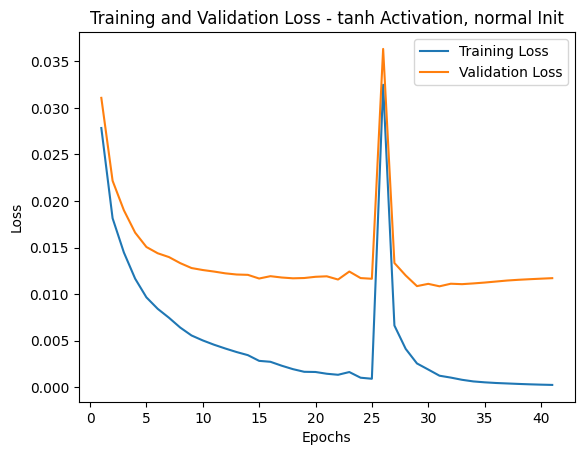

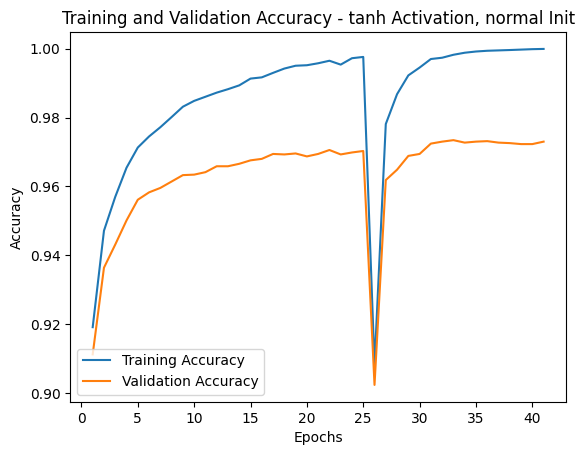

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved in Google Drive as /content/drive/MyDrive/NNN_models/model_tanh_normal.pkl
Training model with tanh activation and zero weight initialization
Epoch 1/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 2/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 3/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 4/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 5/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 6/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 7/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 8/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 9/100 - Train L

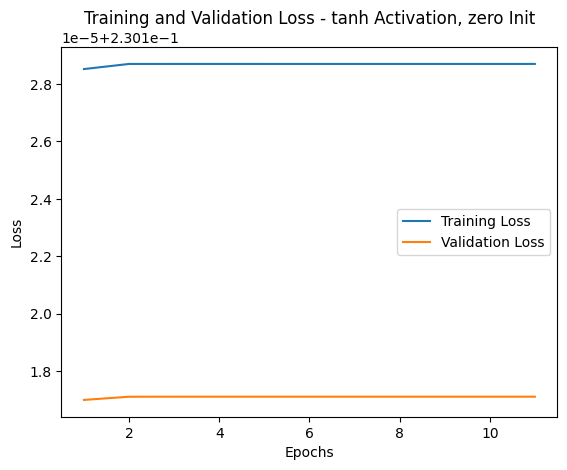

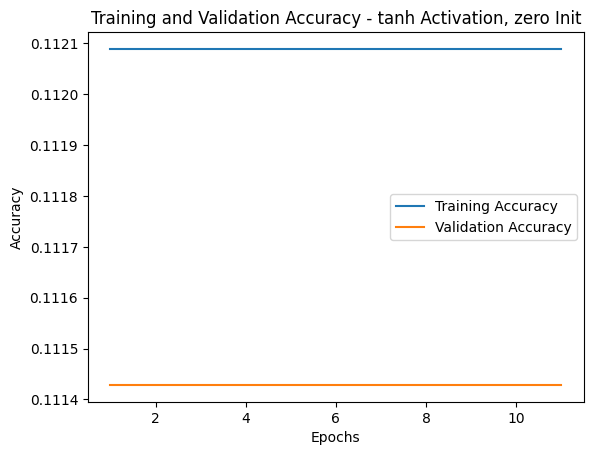

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved in Google Drive as /content/drive/MyDrive/NNN_models/model_tanh_zero.pkl
Training model with tanh activation and random weight initialization
Epoch 1/100 - Train Loss: 0.1837, Val Loss: 0.1845, Train Acc: 0.2593, Val Acc: 0.2594
Epoch 2/100 - Train Loss: 0.1655, Val Loss: 0.1665, Train Acc: 0.3461, Val Acc: 0.3447
Epoch 3/100 - Train Loss: 0.1580, Val Loss: 0.1588, Train Acc: 0.3830, Val Acc: 0.3787
Epoch 4/100 - Train Loss: 0.1454, Val Loss: 0.1461, Train Acc: 0.4405, Val Acc: 0.4316
Epoch 5/100 - Train Loss: 0.1203, Val Loss: 0.1213, Train Acc: 0.5957, Val Acc: 0.5937
Epoch 6/100 - Train Loss: 0.1005, Val Loss: 0.1023, Train Acc: 0.6441, Val Acc: 0.6459
Epoch 7/100 - Train Loss: 0.0764, Val Loss: 0.0790, Train Acc: 0.7428, Val Acc: 0.7339
Epoch 8/100 - Train Loss: 0.0532, Val Loss: 0.0557, Train Acc: 0.8426, Val Acc: 0.8407
Epoch 9/100 - Train L

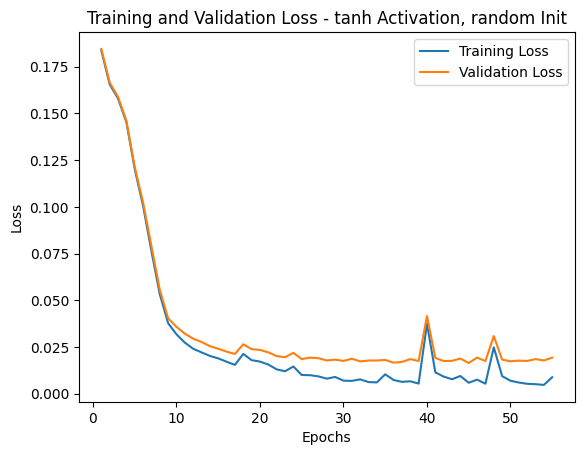

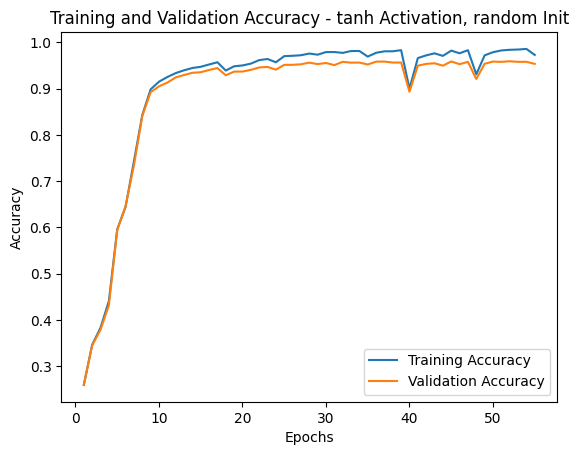

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved in Google Drive as /content/drive/MyDrive/NNN_models/model_tanh_random.pkl
Training model with relu activation and normal weight initialization
Epoch 1/100 - Train Loss: 0.0182, Val Loss: 0.0209, Train Acc: 0.9445, Val Acc: 0.9357
Epoch 2/100 - Train Loss: 0.0111, Val Loss: 0.0147, Train Acc: 0.9657, Val Acc: 0.9551
Epoch 3/100 - Train Loss: 0.0080, Val Loss: 0.0123, Train Acc: 0.9749, Val Acc: 0.9619
Epoch 4/100 - Train Loss: 0.0060, Val Loss: 0.0110, Train Acc: 0.9812, Val Acc: 0.9654
Epoch 5/100 - Train Loss: 0.0043, Val Loss: 0.0099, Train Acc: 0.9872, Val Acc: 0.9696
Epoch 6/100 - Train Loss: 0.0035, Val Loss: 0.0095, Train Acc: 0.9896, Val Acc: 0.9716
Epoch 7/100 - Train Loss: 0.0032, Val Loss: 0.0098, Train Acc: 0.9902, Val Acc: 0.9716
Epoch 8/100 - Train Loss: 0.0023, Val Loss: 0.0094, Train Acc: 0.9934, Val Acc: 0.9721
Epoch 9/100 - Train

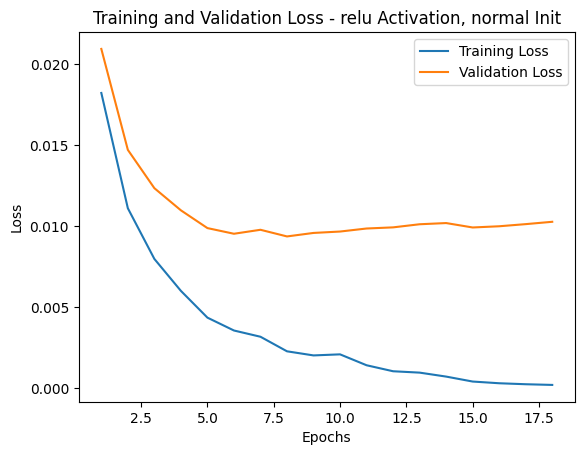

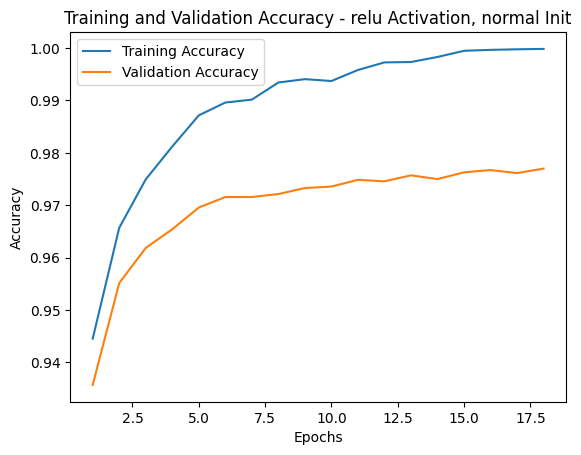

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved in Google Drive as /content/drive/MyDrive/NNN_models/model_relu_normal.pkl
Training model with relu activation and zero weight initialization
Epoch 1/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 2/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 3/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 4/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 5/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 6/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 7/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 8/100 - Train Loss: 0.2301, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 9/100 - Train L

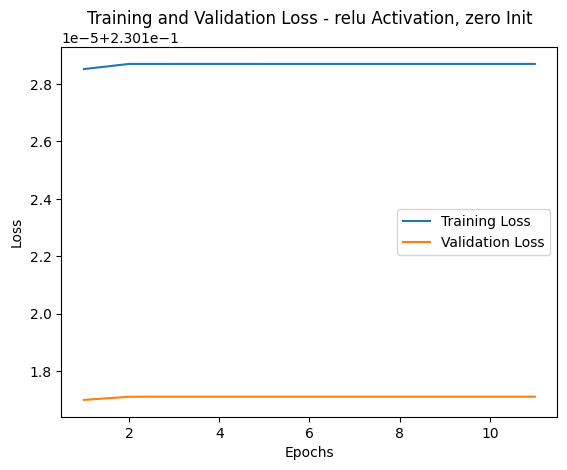

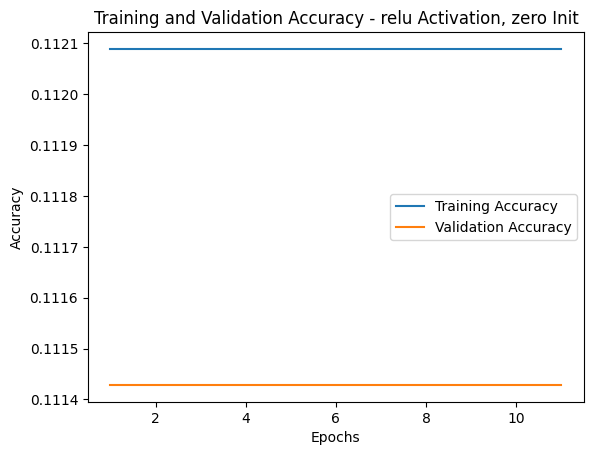

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved in Google Drive as /content/drive/MyDrive/NNN_models/model_relu_zero.pkl
Training model with relu activation and random weight initialization
Epoch 1/100 - Train Loss: 0.1827, Val Loss: 0.1840, Train Acc: 0.2566, Val Acc: 0.2543
Epoch 2/100 - Train Loss: 0.1612, Val Loss: 0.1630, Train Acc: 0.3201, Val Acc: 0.3246
Epoch 3/100 - Train Loss: 0.1491, Val Loss: 0.1502, Train Acc: 0.3575, Val Acc: 0.3577
Epoch 4/100 - Train Loss: 0.1419, Val Loss: 0.1430, Train Acc: 0.3894, Val Acc: 0.3861
Epoch 5/100 - Train Loss: 0.1362, Val Loss: 0.1379, Train Acc: 0.4077, Val Acc: 0.4050
Epoch 6/100 - Train Loss: 0.1328, Val Loss: 0.1346, Train Acc: 0.3954, Val Acc: 0.3886
Epoch 7/100 - Train Loss: 0.1254, Val Loss: 0.1276, Train Acc: 0.4323, Val Acc: 0.4237
Epoch 8/100 - Train Loss: 0.1280, Val Loss: 0.1314, Train Acc: 0.4255, Val Acc: 0.4231
Epoch 9/100 - Train L

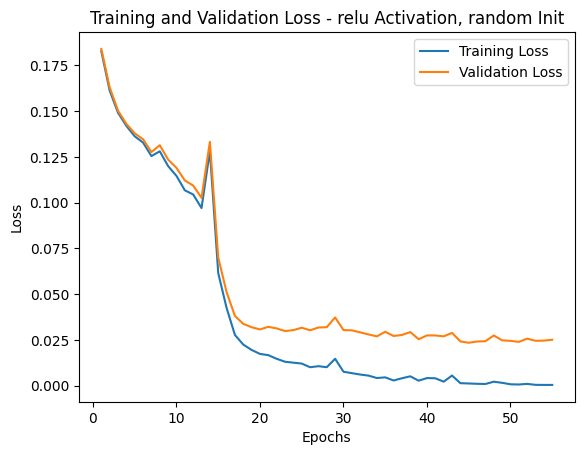

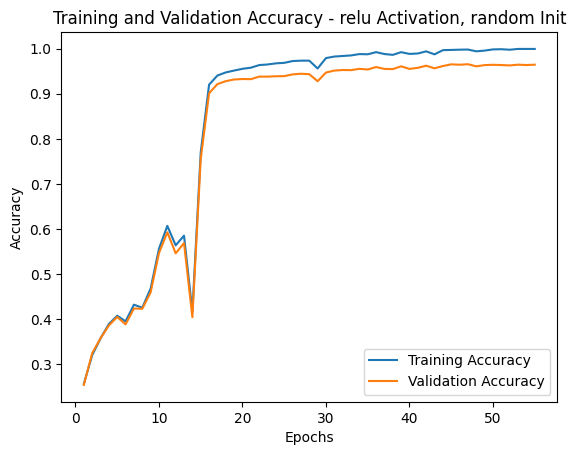

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved in Google Drive as /content/drive/MyDrive/NNN_models/model_relu_random.pkl
Training model with sigmoid activation and normal weight initialization
Epoch 1/100 - Train Loss: 0.2295, Val Loss: 0.2293, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 2/100 - Train Loss: 0.2272, Val Loss: 0.2271, Train Acc: 0.1255, Val Acc: 0.1211
Epoch 3/100 - Train Loss: 0.2010, Val Loss: 0.2016, Train Acc: 0.2716, Val Acc: 0.2644
Epoch 4/100 - Train Loss: 0.1790, Val Loss: 0.1805, Train Acc: 0.3616, Val Acc: 0.3544
Epoch 5/100 - Train Loss: 0.1706, Val Loss: 0.1722, Train Acc: 0.3456, Val Acc: 0.3369
Epoch 6/100 - Train Loss: 0.1528, Val Loss: 0.1542, Train Acc: 0.4069, Val Acc: 0.3940
Epoch 7/100 - Train Loss: 0.1466, Val Loss: 0.1481, Train Acc: 0.4152, Val Acc: 0.3996
Epoch 8/100 - Train Loss: 0.1477, Val Loss: 0.1489, Train Acc: 0.4122, Val Acc: 0.4004


<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 9/100 - Train Loss: 0.1489, Val Loss: 0.1501, Train Acc: 0.3980, Val Acc: 0.3869


<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 10/100 - Train Loss: 0.1414, Val Loss: 0.1422, Train Acc: 0.4580, Val Acc: 0.4557


<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 11/100 - Train Loss: 0.1325, Val Loss: 0.1337, Train Acc: 0.4758, Val Acc: 0.4694


<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 12/100 - Train Loss: 0.1235, Val Loss: 0.1247, Train Acc: 0.5399, Val Acc: 0.5369


<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 13/100 - Train Loss: 0.1170, Val Loss: 0.1178, Train Acc: 0.5772, Val Acc: 0.5737


<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 14/100 - Train Loss: 0.1104, Val Loss: 0.1103, Train Acc: 0.6081, Val Acc: 0.6096


<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 15/100 - Train Loss: 0.1038, Val Loss: 0.1039, Train Acc: 0.6336, Val Acc: 0.6309


<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 16/100 - Train Loss: 0.0972, Val Loss: 0.0977, Train Acc: 0.6631, Val Acc: 0.6671


<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 17/100 - Train Loss: 0.0877, Val Loss: 0.0887, Train Acc: 0.7041, Val Acc: 0.6990


<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 18/100 - Train Loss: 0.0816, Val Loss: 0.0835, Train Acc: 0.7269, Val Acc: 0.7217


<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 19/100 - Train Loss: 0.0772, Val Loss: 0.0792, Train Acc: 0.7444, Val Acc: 0.7401


<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 20/100 - Train Loss: 0.0734, Val Loss: 0.0758, Train Acc: 0.7594, Val Acc: 0.7531


<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 21/100 - Train Loss: 0.0707, Val Loss: 0.0734, Train Acc: 0.7727, Val Acc: 0.7671


<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 22/100 - Train Loss: 0.0692, Val Loss: 0.0721, Train Acc: 0.7796, Val Acc: 0.7710


<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 23/100 - Train Loss: 0.0683, Val Loss: 0.0711, Train Acc: 0.7843, Val Acc: 0.7759


<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 24/100 - Train Loss: 0.0669, Val Loss: 0.0697, Train Acc: 0.7856, Val Acc: 0.7809


<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 25/100 - Train Loss: 0.0656, Val Loss: 0.0685, Train Acc: 0.7899, Val Acc: 0.7880


<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 26/100 - Train Loss: 0.0648, Val Loss: 0.0681, Train Acc: 0.7949, Val Acc: 0.7873


<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 27/100 - Train Loss: 0.0650, Val Loss: 0.0681, Train Acc: 0.7956, Val Acc: 0.7891


<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 28/100 - Train Loss: 0.0650, Val Loss: 0.0683, Train Acc: 0.7945, Val Acc: 0.7927


<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 29/100 - Train Loss: 0.0648, Val Loss: 0.0680, Train Acc: 0.7967, Val Acc: 0.7949


<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 30/100 - Train Loss: 0.0644, Val Loss: 0.0679, Train Acc: 0.7996, Val Acc: 0.7949


<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 31/100 - Train Loss: 0.0645, Val Loss: 0.0672, Train Acc: 0.7970, Val Acc: 0.7976


<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 32/100 - Train Loss: 0.0657, Val Loss: 0.0680, Train Acc: 0.7934, Val Acc: 0.7919


<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 33/100 - Train Loss: 0.0677, Val Loss: 0.0701, Train Acc: 0.7883, Val Acc: 0.7850


<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 34/100 - Train Loss: 0.0698, Val Loss: 0.0718, Train Acc: 0.7786, Val Acc: 0.7774


<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 35/100 - Train Loss: 0.0717, Val Loss: 0.0741, Train Acc: 0.7669, Val Acc: 0.7689


<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 36/100 - Train Loss: 0.0718, Val Loss: 0.0748, Train Acc: 0.7658, Val Acc: 0.7649


<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 37/100 - Train Loss: 0.0712, Val Loss: 0.0742, Train Acc: 0.7714, Val Acc: 0.7647


<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 38/100 - Train Loss: 0.0710, Val Loss: 0.0742, Train Acc: 0.7745, Val Acc: 0.7676


<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 39/100 - Train Loss: 0.0721, Val Loss: 0.0741, Train Acc: 0.7701, Val Acc: 0.7693


<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 40/100 - Train Loss: 0.0713, Val Loss: 0.0738, Train Acc: 0.7689, Val Acc: 0.7660


<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-114-d738f8f31e52>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 41/100 - Train Loss: 0.0703, Val Loss: 0.0727, Train Acc: 0.7722, Val Acc: 0.7669
Early stopping at epoch 41 due to no improvement in validation loss.


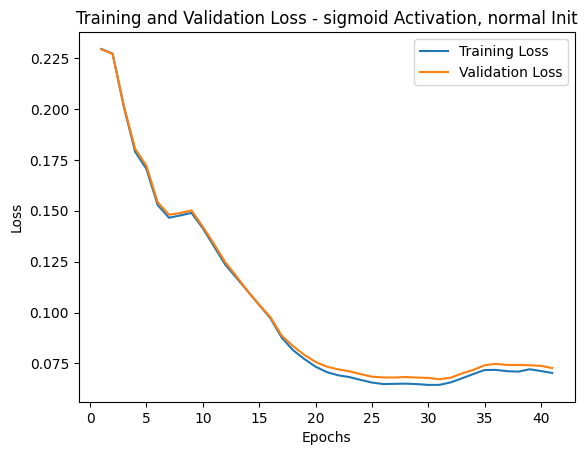

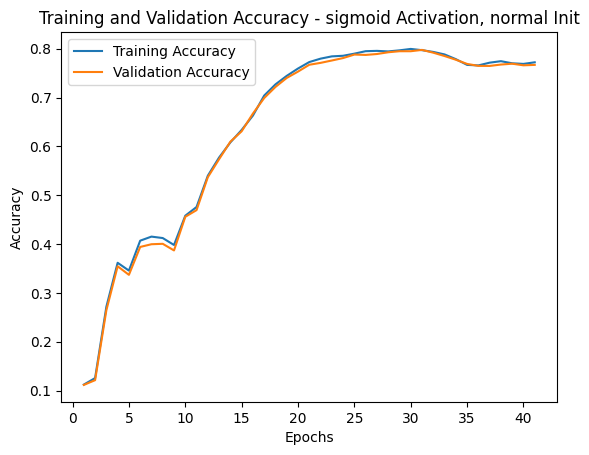

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved in Google Drive as /content/drive/MyDrive/NNN_models/model_sigmoid_normal.pkl
Training model with sigmoid activation and zero weight initialization
Epoch 1/100 - Train Loss: 0.2303, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 2/100 - Train Loss: 0.2303, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 3/100 - Train Loss: 0.2303, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 4/100 - Train Loss: 0.2302, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 5/100 - Train Loss: 0.2302, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 6/100 - Train Loss: 0.2302, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 7/100 - Train Loss: 0.2302, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 8/100 - Train Loss: 0.2302, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 9/100 - T

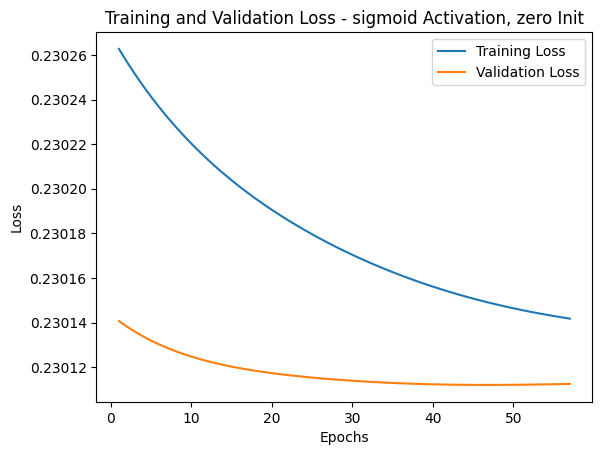

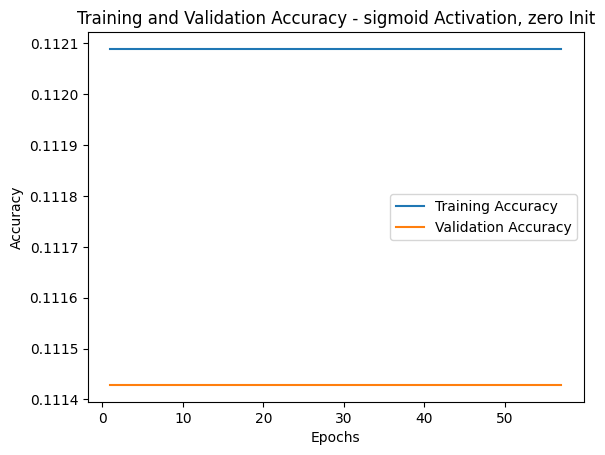

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved in Google Drive as /content/drive/MyDrive/NNN_models/model_sigmoid_zero.pkl
Training model with sigmoid activation and random weight initialization
Epoch 1/100 - Train Loss: 0.2303, Val Loss: 0.2302, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 2/100 - Train Loss: 0.2303, Val Loss: 0.2302, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 3/100 - Train Loss: 0.2303, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 4/100 - Train Loss: 0.2303, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 5/100 - Train Loss: 0.2303, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 6/100 - Train Loss: 0.2302, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 7/100 - Train Loss: 0.2302, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 8/100 - Train Loss: 0.2302, Val Loss: 0.2301, Train Acc: 0.1121, Val Acc: 0.1114
Epoch 9/100 - T

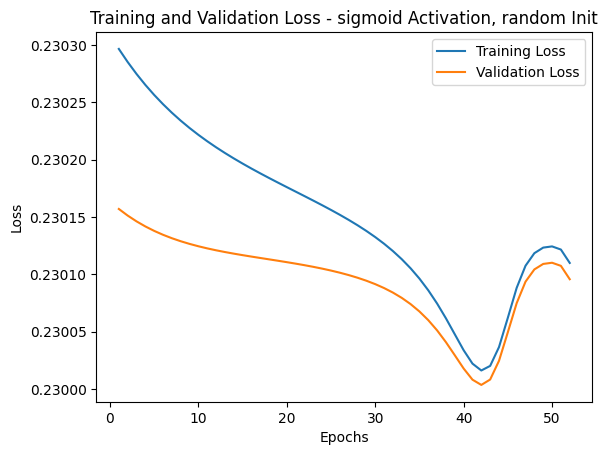

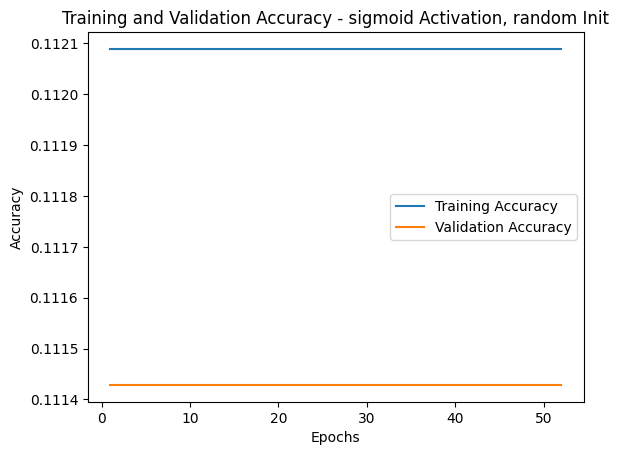

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved in Google Drive as /content/drive/MyDrive/NNN_models/model_sigmoid_random.pkl


In [ ]:
from google.colab import drive
import pickle
import os

def train_and_evaluate_model(activation, weight_init, model_name, patience=10):
    # Initialize the model
    nn = NeuralNetwork(
        layers=[784, 256, 128, 64, 32, 10],  # input size 784, hidden layers, output size 10
        lr=0.1,
        activation=activation,
        weight_init=weight_init,
        epochs=100,
        batch_size=128
    )

    # Track loss and accuracy over epochs
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(nn.epochs):
        # Train the model on training data
        nn.fit(X_train, y_train)

        # Calculate training loss and accuracy
        train_pred = nn.predict_proba(X_train)
        train_loss = -np.mean(y_train * np.log(train_pred + 1e-8))
        train_accuracy = nn.score(X_train, y_train)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Calculate validation loss and accuracy
        val_pred = nn.predict_proba(X_val)
        val_loss = -np.mean(y_val * np.log(val_pred + 1e-8))
        val_accuracy = nn.score(X_val, y_val)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{nn.epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1} due to no improvement in validation loss.")
                break

    # Plot training and validation loss
    plt.figure()
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Training and Validation Loss - {activation} Activation, {weight_init} Init")
    plt.legend()
    plt.show()

    # Plot training and validation accuracy
    plt.figure()
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Training and Validation Accuracy - {activation} Activation, {weight_init} Init")
    plt.legend()
    plt.show()

    # Save the model to Google Drive
    drive.mount('/content/drive')
    drive_path = '/content/drive/MyDrive/NNN_models/'
    os.makedirs(drive_path, exist_ok=True)
    with open(os.path.join(drive_path, f'{model_name}.pkl'), 'wb') as f:
        pickle.dump(nn, f)
    print(f"Model saved in Google Drive as {os.path.join(drive_path, model_name)}.pkl")

# Define combinations of activation functions and weight initializations
activations = ['leaky_relu','tanh', 'relu', 'sigmoid']
weight_initializations = ['normal', 'zero', 'random']

# Train models for each combination and save them with early stopping
for activation in activations:
    for weight_init in weight_initializations:
        model_name = f"model_{activation}_{weight_init}"
        print(f"Training model with {activation} activation and {weight_init} weight initialization")
        train_and_evaluate_model(activation, weight_init, model_name, patience=10)
